In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from template_funciones import *
from template_funciones_2 import *
from scipy.linalg import solve_triangular

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [3]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [5]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partiendo de la ecuación 3, tenemos:

$$
p = (1 - \alpha)Cp + \frac{\alpha}{N} \cdot \mathbf{1}
$$

Luego pasamos restando y tenemos:

$$
p - (1 - \alpha)Cp = \frac{\alpha}{N} \cdot \mathbf{1}
$$

Si factorizamos por $p$, sabiendo que $Ip = p$, tenemos:

$$
(I - (1 - \alpha)C)p = \frac{\alpha}{N} \cdot \mathbf{1}
$$


Multiplicamos a ambos lados por $\frac{N}{\alpha}$, pues $( \alpha \neq 0)$, y obtenemos:


$$
\frac{N}{\alpha}(I - (1 - \alpha)C)p = \mathbf{1}
$$

Que es justamente $Mp = b$


## Punto 2:
Para que la ecuación tenga una unica solución, la matriz $M$ debe ser inversible tal que:
$$
Mp = b \quad \iff \quad p = M^{-1}b
$$
para que $M$ sea inversible hay que analizar su definición:

$$
M = \frac{N}{\alpha} (I - (1 - \alpha ) C)
$$
$C$ es la matriz de transiciones y tiene la propiedad de ser estocástica por columnas (es decir, cada una de sus columnas suman 1).

Por otro lado, $ \alpha \in (0;1) \implies 1 - \alpha \in (0;1)$

Consideremos
$$
B = (1-\alpha) \cdot C 
$$

Entonces B es una matriz con valores $B_{\text{ij}} \in (0;1)$, pues $C$ tenía todos sus valores en el rango $(0;1)$
Además, tenemos que:

$$
||B||_1 < 1 
$$

Pues $||C||_1 = 1$ y estoy multiplicando cada elemento por valores entre 0 y 1 (se hacen más chicos los elementos).

Me queda entonces que

$$
M = \frac {N}{\alpha} (I - B)
$$

A partir de acá armamos dos demostraciones de la inversibilidad de M.

# Prueba por absurdo


El $\frac{N}{\alpha}$ es un escalar, por lo que no afecta a la inversibilidad. Es decir que puedo escribir:

$$
M' = (I - B)
$$

Y sucede que

$M$ es inversible $\iff M'$ es inversible


Queremos probar entonces por absurdo que $M'$ es inversible por absurdo:

Asumamos que $(I - B)$ $NO$ es inversible, por lo tanto $det(I-B) = 0$
Si el determinante es igual a 0, entonces existe un vector no nulo que me lleva al nucleo de la matriz. Es decir:

$$
\exists v \neq 0 \quad/\quad (I- B)v = 0
$$

Distribuyendo:


$$
Iv = Bv
$$
$$
v = Bv
$$
Entonces $v$ es un autovector de $B$ que tiene un autovalor de $1$
$$
||v||_1 = ||Bv||_1
$$
$$
||Bv||_1 \leq ||B||_1 \cdot ||v||_1
$$
Pero
$$
||v||_1 = ||Bv||_1
$$
Entonces
$$
||v||_1 \leq ||B||_1 \cdot ||v||_1
$$
$$
1 \leq ||B||_1
$$

Esto contradice que $||B||_1 < 1 $ entonces $Absurdo!$

Se concluye entonces que $M$ es inversible y por lo tanto tiene unica solución $\square$

# Prueba directa con serie geométrica
Al igual que en la prueba anterior, queremos ver que $I-B$ es inversible. Conjeturamos entonces:
$$(I - B)^{-1} = \sum_{k=0}^{\infty} B^k$$
Veamos que esta sumatoria es efectivamente la inversa de $I-B$.
$$(I-B)^{-1} = \sum_{k=0}^{\infty} B^k \iff (I-B) \cdot \sum_{k=0}^{\infty} B^k = I$$
Si llamamos $S=\sum_{k=0}^{\infty} B^k = I+B+B^2 + B^3 + ... + B^\infty$ tenemos:
$$(I-B)S = I$$
Como $||B||_1 < 1$ y la norma es submultiplicativa, entonces tenemos que:
$$
||B^k||_1 \leq ||B||_1^k
$$
Por lo tanto:
$$
\sum_{k=0}^{\infty}||B^k||_1 \leq \sum_{k=0}^{\infty}||B||_1^k
$$
Esto es una serie geométrica convergente pues $||B||_1 < 1$. En particular:
$$
S=\sum_{k=0}^{\infty}||B||_1^k = \frac{1}{1-||B||_1} < \infty
$$
Y la serie de matrices dada por S converge absolutamente.
Intuitivamente podemos ver que al aplicar la distributiva se van cancelando los términos:
$$
(I-B)S = (I-B)(I+B+B^2+B^3+...+B^x) = I + B^2 -B^2 + B^3-B^3 + ... + B^n - B^n = I 
$$

Que es justamente lo que queríamos probar. Por lo tanto 
$$
(I-B)^{-1} = S
$$
Teníamos 
$$M = \frac{N}{\alpha}(I-B)$$
Y sucede que: 
$$ M \space \text{es inversible} \iff (I-B) \space \text{es inversible}$$

Ya que multiplicar por un escalar no afecta a la inversibilidad, entonces
$M$ es inversible y la ecuación $Mp = b$ tiene solución única. $\square$

## Punto 3:

In [11]:
def graficar(A, p, m, alfa, ax=None):
    G = nx.from_numpy_array(A)
    factor_escala = 1e4  # Escala para los tamaños de nodo    
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))  # Por si se llama suelto sin subplot

    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)

    labels = {i: str(i) for i in G.nodes}

    ax.set_title(rf"PageRank con $m={m}$ y $\alpha={alfa}$", fontsize=10)

    nx.draw_networkx(
        G, pos=G_layout, node_size=p * factor_escala,
        ax=ax, with_labels=False
    )
    nx.draw_networkx_labels(
        G, pos=G_layout, labels=labels,
        font_size=6, font_color="k", ax=ax
    )


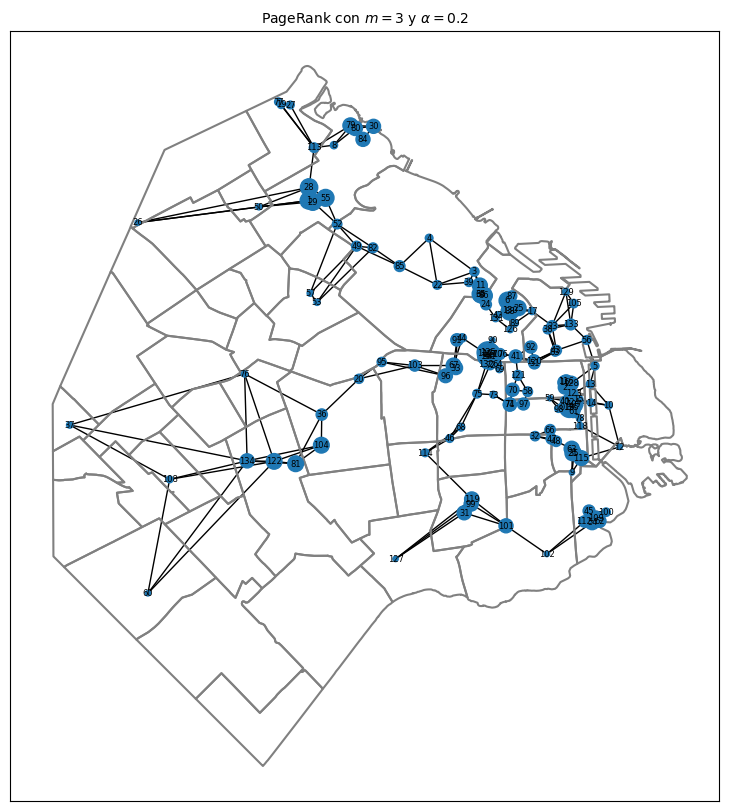

In [12]:
# Punto a
alfa = 1/5
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)
p =calcula_pagerank(A, alfa)
graficar(A, p,m,alfa)

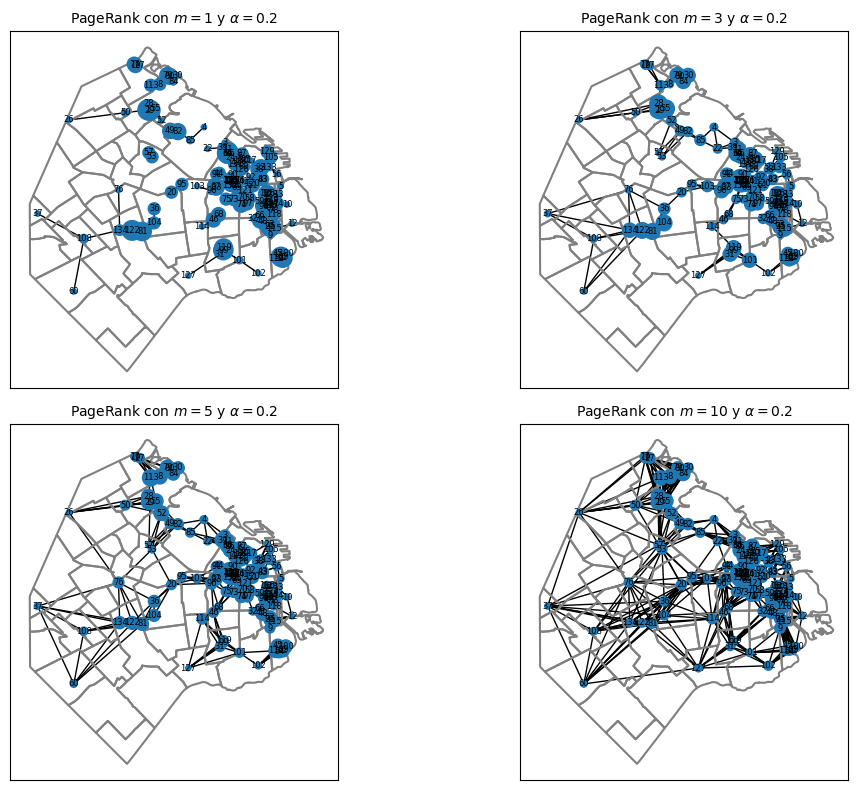

In [13]:
alfa = 1/5
M = [1, 3, 5, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 4 subplots en una grilla 2x2
axs = axs.flatten()  # Para poder usar axs[0], axs[1], etc.

for i, m in enumerate(M):  # <--- ESTA línea es clave
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alfa)
    graficar(A, p, m, alfa, ax=axs[i])  # Ahora sí, axs[i] es correcto

plt.tight_layout()
plt.show()


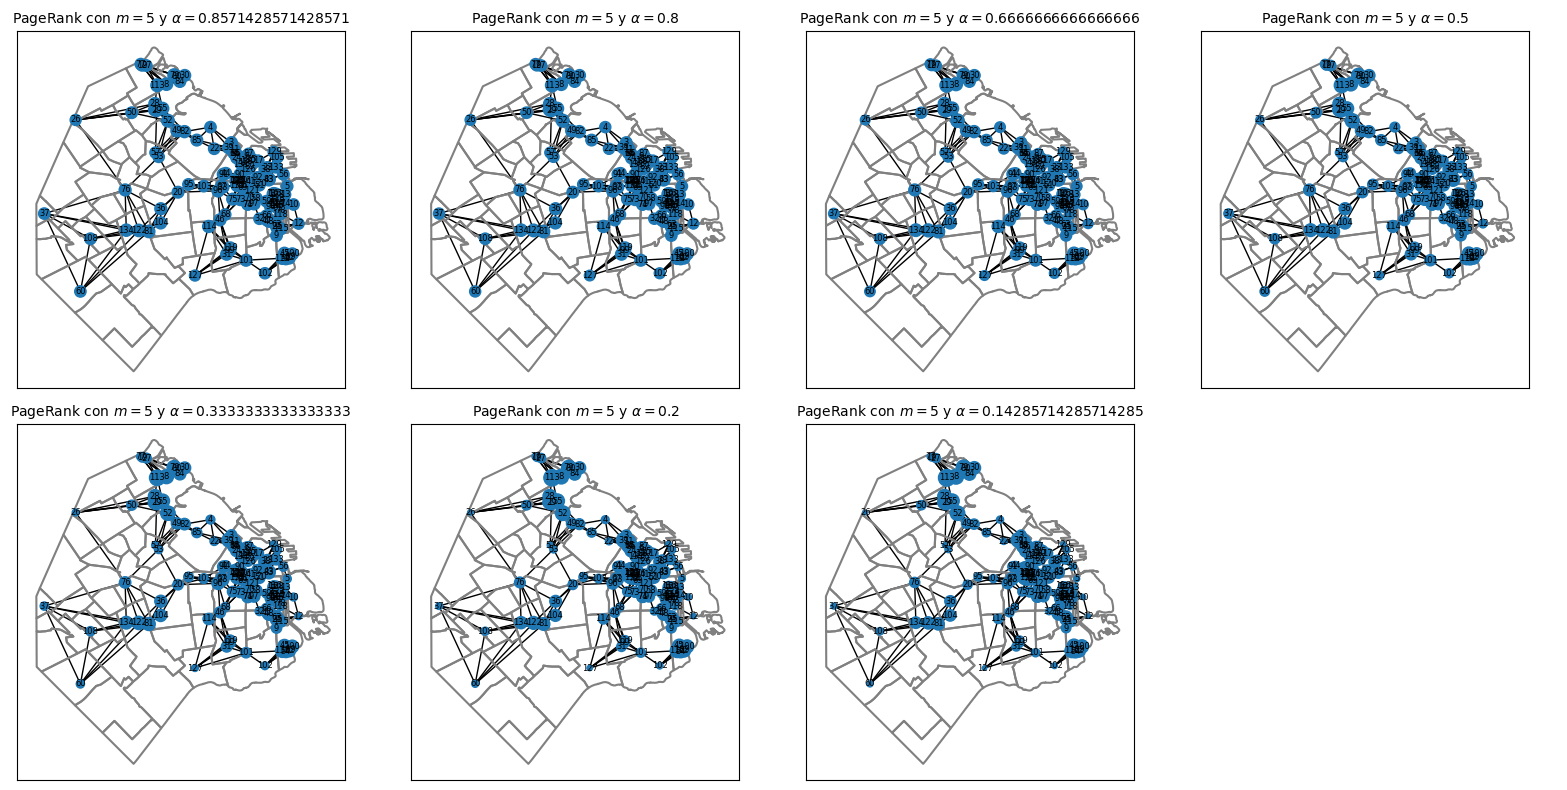

In [14]:
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
m = 5

fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 filas, 4 columnas (8 espacios)
axs = axs.flatten()

for i, alfa in enumerate(alphas):
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alfa)
    graficar(A, p, m, alfa, ax=axs[i])  # Pasamos el subplot correspondiente

# Ocultamos el último subplot que no se usa (ya que hay 7 alphas y 8 subplots)
for j in range(len(alphas), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


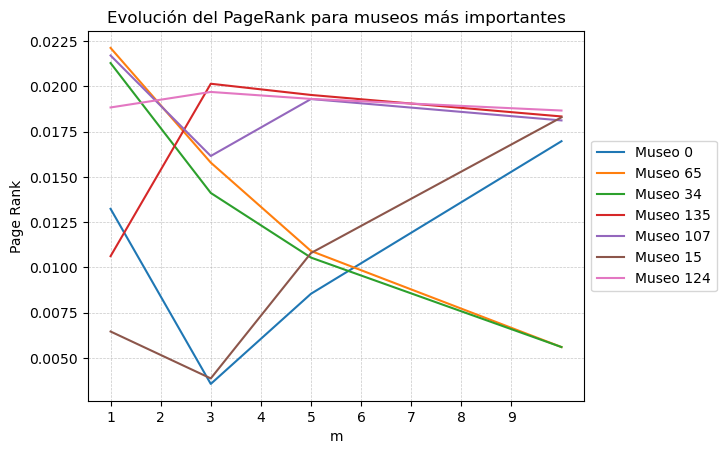

In [15]:
# Parte 2 - (a) - Variando m
M = [1,3,5,10]
size_M = len(M)
n = 3
alfa = 1/5

# Guardamos los valores del pagerank para cada museo para cada m ()
PR = [[0 for _ in range(len(D))] for _ in range(size_M)] 
for i in range(size_M):
    A = construye_adyacencia(D, M[i])
    p = calcula_pagerank(A, alfa)
    PR[i] = p

# Una vez que tenemos los valores calculados del pageRank para cada m, queremos obtener los 3 museos centrales para cada m dado (pueden no ser los mismos).
# Como maximo tenemos size_M * 3 museos distintos, que en este caso serían 12 museos como máximo. Estos son los que vamos a trackear su evolución
# para distintos valores de m.

principales_con_repetidos = [0 for _ in range(size_M*3)]

# --- TODO --- Tomo los 3 indices de los maximos por cada fila y los 
for i in range(0, size_M, 3):
    pcopy = PR[i].copy().flatten()
    top3_indices = np.argsort(pcopy)[-3:][::-1] # Sorteo de menor a mayor los valores de p[i] el vector de pageRank para m = M[i],
    # después tomo los indices de los 3 ultimos valores (mayores) y los revierto para que queden de mayor a menor.
    principales_con_repetidos[i] = top3_indices[0]
    principales_con_repetidos[i+1] = top3_indices[1]
    principales_con_repetidos[i+2] = top3_indices[2]

principales = set()
for elem in principales_con_repetidos:
    if elem not in principales:
        principales.add(elem)
principales_array = np.array(list(principales))

# Para saber los distintos valores de pageRank para distintas m de un mismo museo tengo que mirar las columnas de PR

cant_importantes = len(principales)
x = M
for i in range(cant_importantes):
    row = [0 for _ in range(size_M)]
    # Miro la columna dada por el indice de cada museo principal, 
    # esto me da sus distintos valores de page rank para distintas m.
    ind = principales_array[i] # Indice del museo que sabemos que es uno de los principales
    for j in range(size_M):
        row[j] = PR[j][ind]
    y = row
    plt.plot(x, y, label =f"Museo {ind}")
    
plt.title("Evolución del PageRank para museos más importantes")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("m")       # Eje X
plt.ylabel("Page Rank")           # Eje Y
plt.xticks(range(1, M[size_M-1], 1))
plt.show()

***Pregunta:*** *¿Hay museos que sólo son relevantes en redes con pocas conexiones? ¿O museos que se vuelven más relevantes mientras más conexiones aparecen?*

***Respuesta:*** Si, hay museos que son relevantes con redes con pocas conexiones. Los museos se vuelven más o menos relevantes dependiendo del valor m (cantidad de conexiones). La prueba de esto es que hay más de 3 museos centrales cuando variamos m (es decir que para m's distintas los 3 museos de page rank más alto son distintos). 

In [17]:
def top3(vector): # Dado un vector de numeros reales positivos, devuelve un vector de tuplas (indice, valor) 
    #para los 3 de mayor valor del vector, ordenados de mayor a menor.
    #Obs: Se asume que el vector tiene más de 3 elementos
    max1 = 0
    max2 = 1
    max3 = 2
    
    # Orden inicial
    if vector[max3] > vector[max2]:
        aux = max3
        max3 = max2
        max2 = aux
    if vector[max2] > vector[max1]:
        aux = max2
        max2 = max1
        max1 = aux
    # Ahora tengo los maximos ordenados para los primeros 3 valores de forma que max1 > max2 > max3

    for i in range(3, len(vector)):
        if(vector[i] > vector[max3]): # Como max3 es el menor de los 3 maximos, si el valor actual es mayor al mismo, este sale del top.
            max3 = i
        # Puede que el nuevo valor sea mayor incluso que max2 o max1, asi que miro ambos y swapeo si es necesario
        if vector[max3] > vector[max2]:
            aux = max3
            max3 = max2
            max2 = aux
        if vector[max2] > vector[max1]:
            aux = max2
            max2 = max1
            max1 = aux
    return [max1, max2, max3]

def top3_v2(vector):
    copia = vector.copy()
    maximos = [-1, -1, -1]
    for j in range(3):
        indice_max = np.argmax(copia)
        copia[indice_max] = float('-inf')
        maximos[j] = indice_max
    return maximos


Text(0, 0.5, 'Page Rank')

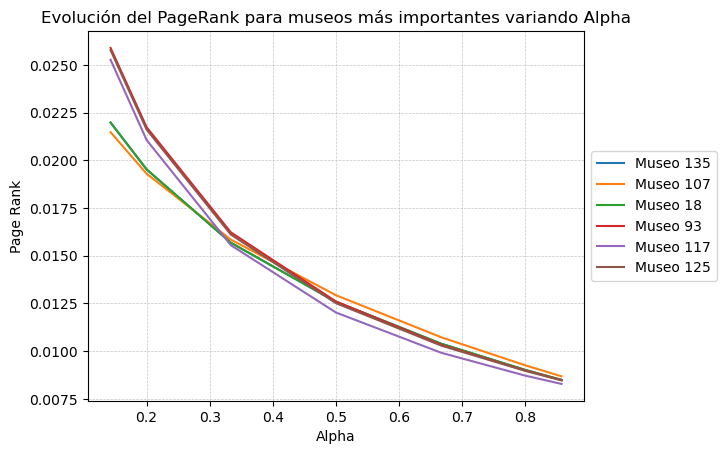

In [18]:
# Parte 2 - (b) - Variando alfa
n = 3
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
size_alphas = len(alphas)
m = 5

# Guardamos los valores del pagerank para cada museo para cada m ()
PR = [[0 for _ in range(len(D))] for _ in range(size_alphas)] 
for i in range(size_alphas):
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alphas[i])
    PR[i] = p

tops = [[0,0,0] for _ in range(size_alphas)] # Tuplas (indice, pagerank) del top 3 para cada alpha

# Una vez que tenemos los valores calculados del pageRank para cada m, queremos obtener los 3 museos centrales para cada m dado (pueden no ser los mismos).
# Como maximo tenemos size_alphas * 3 museos distintos, que en este caso serían 21 museos como máximo. Estos son los que vamos a trackear su evolución
# para distintos valores de m.

# Quiero armarme un conjunto con todos los índices de los museos que pertenecen a algún top 3.
museos_top = set()
for i in range(size_alphas):
    tops[i] = top3_v2(PR[i])
    museos_top.add(tops[i][0])
    museos_top.add(tops[i][1])
    museos_top.add(tops[i][2])

array_museos_top = np.array(list(museos_top))
# Para saber los distintos valores de pageRank para distintas m de un mismo museo tengo que mirar las columnas de PR

cant_importantes = len(array_museos_top)
x = alphas
for i in range(cant_importantes):
    row = [0 for _ in range(size_alphas)]
    # Miro la columna dada por el indice de cada museo principal, 
    # esto me da sus distintos valores de page rank para distintas m.
    ind = array_museos_top[i] # Indice del museo que sabemos que es uno de los principales
    for j in range(size_alphas):
        row[j] = PR[j][ind]
    y = row
    plt.plot(x, y, label =f"Museo {ind}")

plt.title("Evolución del PageRank para museos más importantes variando Alpha")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Alpha")       # Eje X
plt.ylabel("Page Rank")           # Eje Y

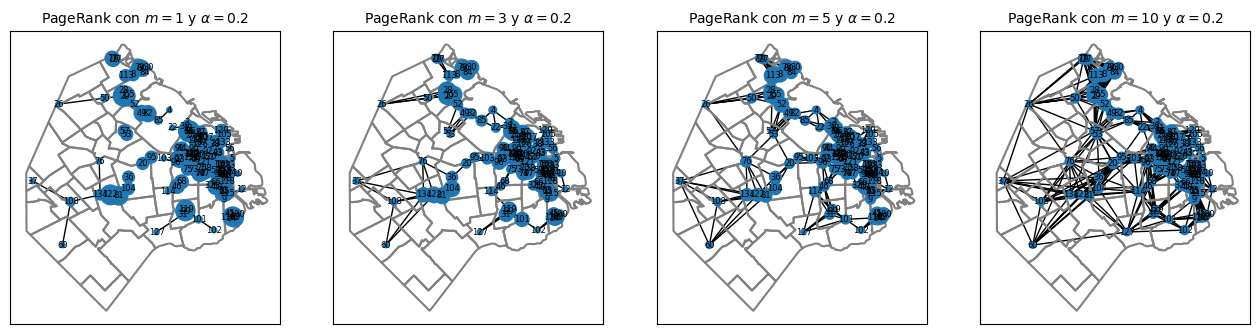

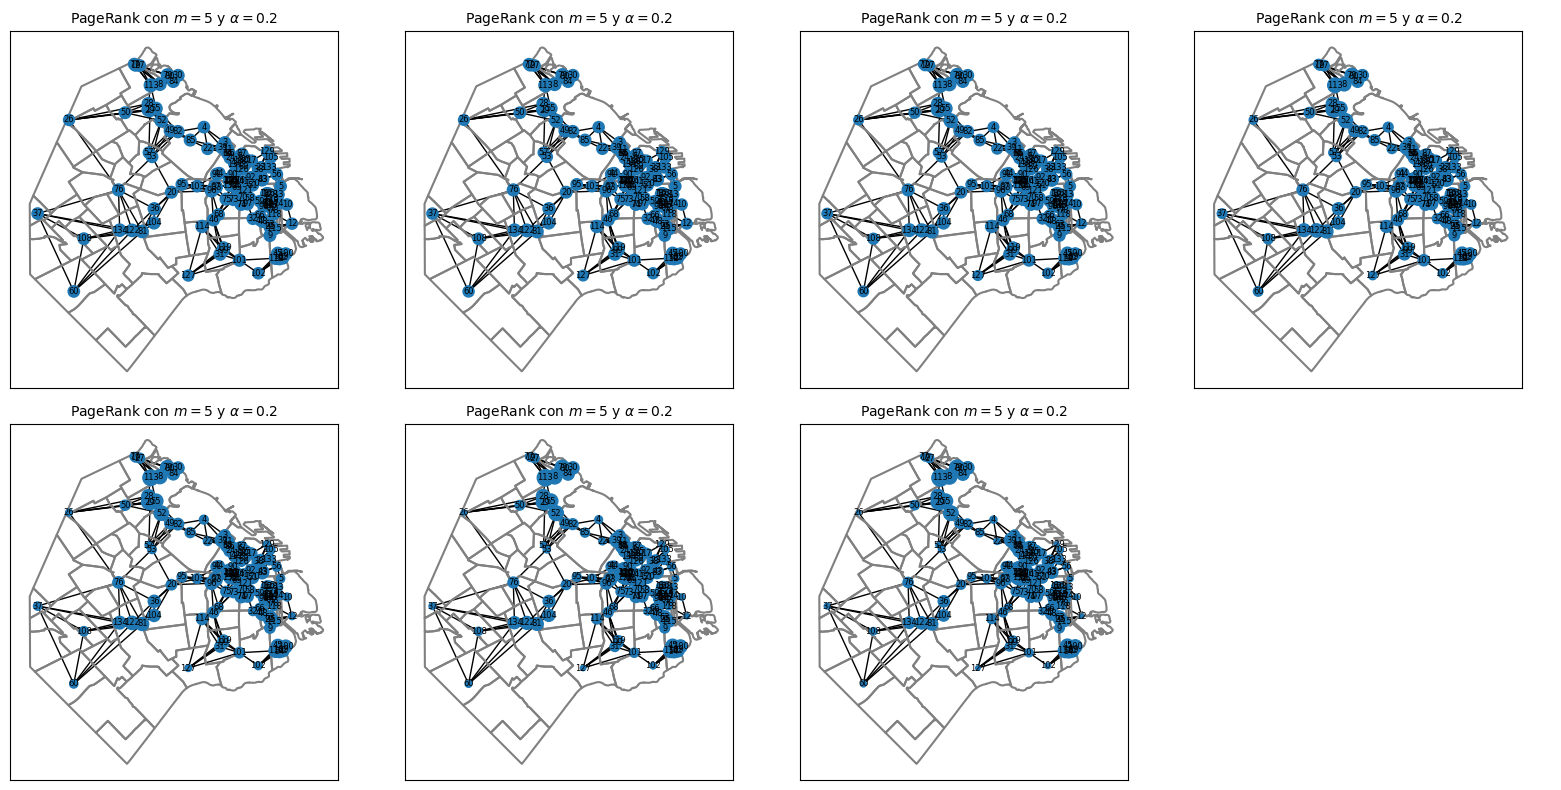

In [19]:
# Punto 3 - Parte II - (b)
M = [1,3,5,10]
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
alfa = 1/5
fig, axs = plt.subplots(1, 4, figsize=(16, 8))  # 2 filas, 4 columnas (8 espacios)
axs = axs.flatten()
for i, m in enumerate(M):
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alfa)
    graficar(A, p, m, alfa, ax=axs[i])  # Pasamos el subplot correspondiente
m = 5
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 filas, 4 columnas (8 espacios)
axs = axs.flatten()
for i, alpha in enumerate(alphas):
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alpha)
    graficar(A, p, m, alfa, ax=axs[i])  # Pasamos el subplot correspondiente
# Ocultamos el último subplot que no se usa (ya que hay 7 alphas y 8 subplots)
for j in range(len(alphas), len(axs)):
    axs[j].axis('off')
plt.tight_layout()
plt.show()



***Pregunta:*** *¿Qué regiones se vuelven más predominantes al aumentar α? ¿Y al aumentar m?*

***Respuesta:*** Al aumentar o disminuir alpha, todos los museos ven afectado su pageRank de manera proporcional, pero esto afecta más a los que tengan más pageRank. Es decir, crece más el pageRank de un museo que tenía un valor base alto al aumentar alpha, y disminuye más al disminuirlo. Al aumentar m, las zonas céntricas se vuelven más relevantes porque tienen más conexiones cercanas, mientras que las zonas más alejadas del centro se vuelven menos relevantes.

## Punto 4:

Partimos de la ecuación:

$$
\mathbf{v} = B^{-1} \cdot \mathbf{w}
$$

Esto es equivalente a:

$$
B \cdot \mathbf{v} = \mathbf{w}
$$

con $B$ inversible. Pero como sabemos que

$$
B = \sum_{k=0}^{r-1} C^k,
$$

entonces:

$$
\left( \sum_{k=0}^{r-1} C^k \right) \cdot \mathbf{v} = \mathbf{w}
$$

lo que equivale a:

$$
(I + C + C^2 + C^3 + \dots + C^{r-1}) \cdot \mathbf{v} = \mathbf{w}
$$

---

Queremos ver que si cada persona realiza $r$ visitas y empieza en un museo dado (determinado por el vector $v$, el total de visitas recibidas por cada museo queda almacenado en $w$, y está dado por:

$$
\mathbf{w} = \left( \sum_{k=0}^{r-1} C^k \right) \cdot \mathbf{v}
$$

   Después de $k$ pasos, la distribución esperada de visitantes es $C^k \cdot \mathbf{v}$, con $C$ la matriz de transiciones. Entonces, el total de visitas será la suma de estas distribuciones desde $k = 0$ hasta algún paso dado (en este caso hasta $r-1$).  
   Esto se debe a que en cada paso se visitan museos: el paso 0 lo determina el vector $v$, que representa la posición inicial de las personas en los museos. Luego, al dar un paso, se mueven según la matriz de transición $C$ y visitan otros museos. En el paso $r$, se habrán movido $r - 1$ pasos, donde cada movimiento aporta visitas a las visitas totales representadas por $w$.

De esta forma:

$$
\mathbf{w} = I\mathbf{v} + C\mathbf{v} + C^2\mathbf{v} + \dots + C^{r-1}\mathbf{v} = \left( \sum_{k=0}^{r-1} C^k \right) \cdot \mathbf{v} = B\mathbf{v}
$$

con el $B$ definido anteriormente.


## Punto 5:

In [24]:
cantidad_de_visitas = 3
w = np.loadtxt("visitas.txt") # Cargo el vector w dado por el archivo visitas.txt

C = calcula_matriz_C_continua(D)
B = calcula_B(C,cantidad_de_visitas)

# C y B no tienen negativos.

L, U = calculaLU(B)
# Dado Bv = w, tengo w y B, quiero calcular v
# LUv = w
# Ly = w con Uv = y

# Resolvemos Bv = w mediante LU
# Ly = w
y = solve_triangular(L, w, lower=True)

#  Uv = y
v = solve_triangular(U, y, lower=False)

print("Vector v de visitantes:")
suma = 0
# Formateo para el print de v
for i, valor in enumerate(v):
    print(f"v[{i:3}] = {valor:8.2f}", end="   ")
    if (i + 1) % 6 == 0: # 6 elementos por linea
        print()
    suma = suma + abs(v[i])
    

print("\nNorma de v: ‖v‖₁ =", f"{suma:.2f}")



Vector v de visitantes:
v[  0] =  1218.87   v[  1] =   555.18   v[  2] =  1376.13   v[  3] =  1358.03   v[  4] =   707.34   v[  5] =  1127.12   
v[  6] =   995.62   v[  7] =  1224.15   v[  8] =   557.62   v[  9] =   937.44   v[ 10] =   647.89   v[ 11] =   652.90   
v[ 12] =  1083.79   v[ 13] =  1147.58   v[ 14] =   805.00   v[ 15] =   958.50   v[ 16] =  1020.22   v[ 17] =  1286.54   
v[ 18] =  1024.08   v[ 19] =  1486.30   v[ 20] =   712.73   v[ 21] =   628.85   v[ 22] =   727.14   v[ 23] =   908.04   
v[ 24] =   657.58   v[ 25] =   843.77   v[ 26] =   666.77   v[ 27] =  1392.04   v[ 28] =   666.96   v[ 29] =  1184.16   
v[ 30] =  1468.07   v[ 31] =   884.90   v[ 32] =  1295.53   v[ 33] =   641.89   v[ 34] =   957.02   v[ 35] =  1351.58   
v[ 36] =  1497.01   v[ 37] =  1064.17   v[ 38] =   920.09   v[ 39] =   760.98   v[ 40] =   697.89   v[ 41] =  1052.21   
v[ 42] =  1361.56   v[ 43] =  1137.46   v[ 44] =   830.46   v[ 45] =   582.96   v[ 46] =  1467.33   v[ 47] =  1470.12   
v[ 48] =

## Punto 6:

Para calcular el número de condición de $B$ en norma 1, tenemos que calcular las normas de $B$ y de su inversa. Es decir:

$$
\text{cond}_1(B) = \|B\|_1 \cdot \|B^{-1}\|_1
$$

Sabemos que la norma 1 de $B$ es la mayor suma absoluta de las columnas de $B$. Ahora bien, sea:

$$
B = \sum_{k=0}^{r-1} C^k
$$

Cada elemento de $B$ es la suma de los elementos de $C^k$ para $k$ desde 0 hasta un cierto $r$ dado. Como $C$ es estocástica (las columnas suman 1), también lo es cada $C^k$, ya que esta propiedad se conserva bajo potencias.

Entonces, en cada sumando de la sumatoria, el valor máximo de la suma de alguna de sus columnas es 1. Dado que hay $r$ sumandos (la identidad también cumple $||I||_1 = 1$), se tiene:

$$
\|B\|_1 = \left\| \sum_{k=0}^{r-1} C^k \right\|_1 = \sum_{k=0}^{r-1} \|C^k\|_1
$$

Dado que todos los elementos de $C$ son positivos, lo cual se preserva en cada $C^k$.

Como $C^k$ es estocástica para todo $k \geq 0$, se cumple que:

$$
\sum_{k=0}^{r-1} \|C^k\|_1 = \sum_{k=0}^{r-1} 1 = r
$$

Por lo tanto:

$$
\|B\|_1 = r
$$

Y entonces tenemos que el número de condición de B es:
$$
\text{cond}_1(B) = r \cdot \|B^{-1}\|_1
$$

In [27]:
def calcula_B(C,cantidad_de_visitas):
    # Recibe la matriz T de transiciones, y calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes
    # suponiendo que cada visitante realizó cantidad_de_visitas pasos
    # C: Matirz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red dado por los visitantes. Indicado como r en el enunciado
    # Retorna:Una matriz B que vincula la cantidad de visitas w con la cantidad de primeras visitas v
    B = np.eye(C.shape[0]) # B = I
    r = cantidad_de_visitas
    C_k = C # C_k = C^1
    for k in range(1, r):
        # Sumamos las matrices de transición para cada cantidad de pasos
        B = B + C_k # B = B + C^k
        C_k = C_k @ C
    return B

# Calculo de número de condición de B
def norma1(A): # Función que calcula la norma 1 de una matriz (o sea la maxima sumatoria de una columna de la misma). Y la devuelve.
    max = 0
    for c in range(len(A)):
        col_sum = 0
        for f in range(len(A)):
            col_sum = col_sum + abs(A[f][c])
        if(col_sum > max):
            max = col_sum
    return max

def condB(B, r): # Calcula el número de condición de la matriz B con r conocido y lo devuelve. Usa r = ||B||_1 para reducir el error.
    # cond(B) = ||B|| * ||B^-1||
    # ||B|| = r
    B_inv = inversa(B)
    norma_inv = norma1(B_inv)
    return r * norma_inv
    
cantidad_de_visitas = 3
C = calcula_matriz_C_continua(D)
B = calcula_B(C,cantidad_de_visitas)
print(f"Número de condición de B para r={cantidad_de_visitas}:", condB(B, cantidad_de_visitas))

Número de condición de B para r=3: 5.0517711766649995


La cota del error relativo en norma 1 viene dada por:

$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq \text{cond}_1(B) \cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$


Y sabemos que $||B||_1 = r$, entonces tenemos:
$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq r * ||B^{-1}||_1\cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$

Sabemos que el error en la medición de w es de 5% (0,05 o $\frac{1}{20}$). Es decir que entonces 
$$\tilde{w} = w * \frac{21}{20}$$
Esto también vale para $w * 0,95 (\frac{19}{20})$ porque la norma lo hace positivo. Por lo tanto tenemos que:
Entonces tenemos que:

$$
\frac{||w-\tilde{w}||_1}{||w||_1} = \frac{||w-(w * \frac{21}{20})||_1}{||w||_1} = \frac{||\frac{-1}{20} \cdot w||_1}{||w||_1} = |\frac{-1}{20}| * \frac{||w||_1}{||w||_1} = \frac{1}{20} = 0,05
$$
Que es efectivamente el error de medición del 5%. Entonces la inecuación para estimar el error del valor v queda:
$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq r * ||B^{-1}||_1 * 0,05
$$

In [29]:
# Estimación de la cota de error para el valor de v
C = calcula_matriz_C_continua(D)
cantidad_de_visitas = 8
B = calcula_B(C, cantidad_de_visitas)
cond_B = condB(B,cantidad_de_visitas)
cota = cond_B * 0.05
print(f"La cota para el error de estimación de v (con r = 3) es: {cota}")
print(f"Esto significa un error del valor de {cota*100} %")

La cota para el error de estimación de v (con r = 3) es: 0.9214953312833759
Esto significa un error del valor de 92.1495331283376 %


# Trabajo Práctico - Parte 2


## Punto 1:

$\textbf{a)}$ Muestren que el vector de unos $\vec{1}$ es autovector de las matrices $R$ y $L$. ¿Qué
autovalor tiene? ¿Y qué agrupación de la red representa?

Por definición, el vector $v = \vec{1}$ es autovector de $L$ si y sólo si cumple:
$$
Lv = \lambda v \iff L\vec{1} = \lambda \vec{1}
$$

Esto es:
$$
\begin{pmatrix}
 L_{11} & L_{12} & \dots & L_{1n} \\
 L_{21} & L_{22} & \dots & L_{2n} \\
 \vdots & \vdots & \ddots & \vdots \\
 L_{n1} & L_{n2} & \dots & L_{nn}
\end{pmatrix}
\cdot 
\begin{pmatrix}
    1 \\ 1 \\ \vdots \\ 1
\end{pmatrix}
=
\begin{pmatrix}
    \lambda \\ \lambda \\ \vdots \\ \lambda 
\end{pmatrix}.
$$

Esto es lo mismo que:
$$
\begin{pmatrix}
    L_{F1} \\ L_{F2} \\ \vdots \\ L_{Fn}
\end{pmatrix}
=
\begin{pmatrix}
    \lambda \\ \lambda \\ \vdots \\ \lambda
\end{pmatrix}
$$
donde $L_{Fi}$ es la sumatoria de la fila $i$ de $L$.

A partir de esto se puede ver que:
$$
\lambda = L_{F1} = L_{F2} = \dots = L_{Fn},
$$
es decir, todas las filas de $L$ suman exactamente $\lambda$.

Sabemos que $L = K - A$, con $A$ la matriz de adyacencia y $K$ definida como:
$$
K_{ij} = 
\begin{cases}
\sum_{h=1}^{N} A_{ih}, & \text{si } i = j, \\
0, & \text{si } i \neq j.
\end{cases}
$$

Por lo tanto:
$$
L = K - A =
\begin{pmatrix}
    K_{11} & -A_{12} & \dots & -A_{1n} \\
    -A_{21} & K_{22} & \dots & -A_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    -A_{n1} & -A_{n2} & \dots & K_{nn}
\end{pmatrix},
$$
pues $K$ es diagonal y $A$ tiene ceros en la diagonal.

Entonces, para cualquier fila $i$ de $L$ vale:
$$
L_{Fi} = \sum_{j=1}^{N} L_{ij} = K_{ii} + \sum_{\substack{j=1 \\ j \neq i}}^{N} (-A_{ij}) = K_{ii} - A_{i},
$$
donde $A_i$ es la suma de la fila $i$ de $A$.

Pero por definición de $K$ sabemos que $K_{ii} = A_i$, entonces:
$$
L_{Fi} = K_{ii} - A_{i} = 0.
$$

Es decir, todas las filas de $L$ suman cero, y en particular el autovalor asociado al autovector de unos es:
$$
\lambda = 0.
$$

El autovector de unos representa la $\textbf{agrupación}$ de todos los vértices en un solo grupo (el de los $1$), y ninguno en el otro (el de los $-1$).

Ahora vamos a ver por R.
Similar que antes, por definición, el vector $v = \vec{1}$ es autovector de $R$ si y sólo si cumple:
$$
Rv = \lambda v \iff R\vec{1} = \lambda \vec{1}
$$

Análogamente, esto es:
$$
\begin{pmatrix}
 R_{11} & R_{12} & \dots & R_{1n} \\
 R_{21} & R_{22} & \dots & R_{2n} \\
 \vdots & \vdots & \ddots & \vdots \\
 R_{n1} & R_{n2} & \dots & R_{nn}
\end{pmatrix}
\cdot 
\begin{pmatrix}
    1 \\ 1 \\ \vdots \\ 1
\end{pmatrix}
=
\begin{pmatrix}
    \lambda \\ \lambda \\ \vdots \\ \lambda 
\end{pmatrix}.
$$

Esto es lo mismo que:
$$
\begin{pmatrix}
    R_{F1} \\ R_{F2} \\ \vdots \\ R_{Fn}
\end{pmatrix}
=
\begin{pmatrix}
    \lambda \\ \lambda \\ \vdots \\ \lambda
\end{pmatrix}
$$

A partir de esto se puede ver que:
$$
\lambda = R_{F1} = R_{F2} = \dots = R_{Fn}
$$

Para poder calcular esto, necesito tener la definición de $R$ la cual es:

$$
R = A - P
$$

Siendo $A$ la matriz de conexiones simétrica y $P$ es la matriz que representa en cada posicion la cantidad esperada de conexiones entre dos nodos, que tambien es simétrica.

La suma de todas las aristas de $A$ está definida como $2E$ y es el doble de la cantidad de aristas del grafo, tal que:

$$
\sum_{i=1}^{N}\sum_{j=1}^{N} A_{ij} = 2E
$$

La construcción de $P$ esta relacionada con los grados de los nodos y se construye como:
$$
P_{ij} = \frac{k_{i}k_{j}}{2E}
$$

Entonces, uniendo todo se obtiene que si restamos la matriz obtenida $A$ menos la matriz esperada $P$ obtenemos la matriz $R$ que representa la relación entre lo obtenido y esperado.

Cada posición de $R$ cumple:
* Si $R_{ij} > 0$ entonces hay mas conexiones reales de las que se esperaría por azar
* Si $R_{ij} < 0$ entonces hay menos conexiones reales de las que se esperaría por azar
* Si $R_{ij} = 0$ entonces las conexiones reales son las mismas que se esperaría por azar

Como bien enunciamos al principio, 

\begin{gather*}
\forall i \in \mathbb{N} \text{ con } 1 \leq i \leq n \\
R_{Fi} = \lambda
\end{gather*}

Ahora vamos a calcular los valores de $R_{Fi}$

Recuerdo que la sumatoria de una fila de $A$ es $\sum_{j=1}^{N} A_{ij} = k_i$ por definición de grado.

Ahora:

$$
\sum_{j=1}^{N} R_{ij} = \sum_{j=1}^{N} (A_{ij} - P_{ij}) = \sum_{j=1}^{N} A_{ij} - \sum_{j=1}^{N} P_{ij} 
$$
y hago el cálculo para $\sum_{j} P_{ij}$.
$$
\sum_{j=1}^{N} P_{ij} = \sum_{j=1}^{N} \frac{k_{i}k_{j}}{2E} = \frac{k_i}{2E} \sum_{j=1}^{N} k_j = \frac{k_i}{2E} \sum_{i=1}^{N}\sum_{j=1}^{N} A_{ij} = \frac{k_i}{2E} \cdot 2E = k_i
$$
entonces todo queda:
$$
\sum_{j=1}^{N} R_{ij} = k_i - k_i = 0
$$

Con este resultado volvemos al comienzo y podemos decir que:
$$
R_{Fi} = \lambda = 0 
$$
entonces,
$$
\lambda = R_{F1} = R_{F2} = \dots = R_{Fn} = 0
$$

Por lo tanto, $\vec{1}$ es autovector de $R$ y su autovalor asociado es $\lambda = 0$.

Igual a L, el autovector de unos representa la $\textbf{agrupación}$ de todos los vértices en un solo grupo (el de los $1$), y ninguno en el otro (el de los $-1$).


$\textbf{b)}$ Muestren que si L (R) tienen dos autovectores $v_1$ y $v_2$ asociados a autovalores
$\lambda_1 \neq \lambda_2$, entonces $v^{t}_1v_2 = 0$.

L y R son matrices simétricas:
* L es simétrica pues $L = K - A$ es la suma de dos matrices simétricas.
* R es simétrica porque es $ R = A - P$ donde A y P son simétricas. P es simétrica pues $P_{ij} = \frac{k_ik_j}{2E} = \frac{k_jk_i}{2E} = P_{ji}$.

$\textbf{Proposición:}$ Sea $M \in \mathbb{K}^{n \times n}$ una matriz simétrica (es decir, $M^t = M$), con autovalores $\lambda_1, \lambda_2, \dots, \lambda_n$, los autovectores asociados $v_1, \dots v_n$ son ortogonales entre sí. Es decir, $\frac{v_1}{||v_1||_2}, \dots, \frac{v_n}{||v_n||_2}$ es una b.o.n. de $\mathbb{K}^{n \times n}$.

Demostración: Sean $v_1, v_2$ dos autovectores de M, con $\lambda_1, \lambda_2$ sus autovalores asociados. Sabemos que vale por definición
$Mv_1 = \lambda_1 v_1, Mv_2 = \lambda_2 v_2$


Tomemos el producto $v_1^t M v_2$
Lo podemos calcular de dos formas:

1.
    $v_1^t M v_2 = v_1^t \lambda_2 v_2 = \lambda_2 v_1^t v_2.$

2. $v_1^t M v_2 = (M^t (v_1^{t})^t)^t v_2 = (Mv_1)^t v_2 = (\lambda_1 v_1)^t v_2 = \lambda_1 v_1^t v_2$


Pero entonces tenemos que 
$$
\lambda_1 v_1^t v_2 = \lambda_2 v_1^t v_2.
$$

O lo que es lo mismo, que 
$$\lambda_1 v_1^t v_2 - \lambda_2 v_1^t v_2 = 0 \iff \underbrace{(\lambda_1 - \lambda_2)}_{\neq 0 \text{ pues } \lambda_1 \neq \lambda_2} (v_1^t v_2) = 0 \iff v_1^t v_2 = 0 \iff \langle v_1, v_2 \rangle = 0 \iff v_1 \perp v_2, \iff v_1 \text{ y } v_2 \text{ son ortogonales.}
$$



Usando la proposición demostrada y el hecho de que L y R son simétricas, tenemos que si $v_1, v_2$ son dos autovectores de dos autovalores distintos, entonces son ortogonales. Es decir, $v_1^tv_2 = <v_1, v_2> = 0$ pues $v_1 \perp v_2$.

$\textbf{c)}$ Muestren si $v$ es un autovector de autovalor $\lambda \neq 0$ de $R$ o $L$, entonces $\sum_i$ $v_i$ = 0

## Punto 2: Extensiones del método de la potencia

Consideren una matriz $M \in \mathbb{R}^{n \times n}$ diagonalizable con autovalores $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n$, y autovector $v_i$ asociado a $\lambda_i$.

### a) Shifting de Autovalores

Muestre que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$,
y que el autovector asociado a $\gamma_i$ es $v_i$. Concluya que si $\mu + \lambda_i \neq 0 \forall i$, entonces
$M + \mu I$ es inversible.

$\textbf{Demostración: }$
Si consideramos $(M + \mu I) v_i = \gamma_i v_i$
$$
(M + \mu I)v_i = Mv_i + \mu v_i = \lambda_i v_i + \mu v_i = (\lambda_i + \mu)v_i
$$

O sea, los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$ y los autovectores son los mismos, pues son los que cumplen por definición:
$$
(M + \mu I) v_i = (\lambda_i + \mu)v_i
$$

Por otra parte, una matriz diagonalizable A se puede escribir como $A = PDP^{-1}$ con D diagonal. Sabemos que A es inversible si y sólo si su determinante es distinto de 0. En particular, sabemos que $det(A) = det(P)\cdot det(D) \cdot det(P^{-1}) = det(D)$. Como D es la matriz diagonal con los autovalores en la diagonal, su determinante es el producto de la diagonal, que es distinto de 0 siempre y cuando ningún autovalor sea 0. 

Basta tomar A = $M + \mu I$ y ya vimos que sus autovalores son $\mu + \lambda_i$, por lo tanto $ \forall i \mu + \lambda_i \neq 0 \iff M + \mu I \text{ es inversible.}$

### b) Método de la potencia inverso

Considerando $\mu > 0$, muestren que $L + \mu I$ es inversible, con L el laplaciano definido en la ecuación 2. Muestren que aplicar el método de la potencia a $(L+ \mu I)^{-1}$ converge a su autovector de autovalor más chico si se parte de una semilla adecuada. Indique, en el caso de que hay sólo un autovector con dicho autovalor, cuál es dicho autovector y cuánto vale su autovalor.

* $\mathbf{L + \mu I}$ es inversible

Tomemos $M = L + \mu I$. Sabemos que M es inversible $\iff det(M) \neq 0$. Por el punto anterior sabemos que M es diagonalizable con sus autovalores $\lambda_i + \mu$ donde $\lambda_i$ es autovalor de L. También vimos que el determinante de una matriz diagonalizable dependía de la productoria de los autovalores. Sabemos que el autovalor más chico de L es 0 (por ser semidefinida positiva). Es decir que el autovalor más chico de M será $\mu$, y M será inversible $\iff \mu > 0$, que es justamente la hipótesis de la que partimos. $\square$



* Aplicar el método de la potencia a $(L + \mu I)^{-1}$ converge a su autovector de autovalor más chico.

Sabemos que $M = L + \mu I$ es inversible por hipótesis (existe su inversa $N = M^{-1}$).

Además, M es diagonalizable, por lo que puede escribirse como $M = PDP^{-1}$. Pero entonces su inversa es
$N = M^{-1} = (PDP^{-1})^{-1} = (P^{-1})^{-1} D^{-1} P^{-1} = PD^{-1}P^{-1}$ donde la inversa de una matriz diagonal es ella misma pero para cada elemento $a$ de la diagonal se reemplaza por $\frac{1}{a}$ (sabemos que $a \neq 0$ pues son los autovalores de M, y el mínimo es $\mu > 0$). Es decir, los autovalores de N son $\frac{1}{\lambda_i + \mu}$ y los autovectores son los mismos que los de M.

Como todos los autovalores son positivos, entonces el autovalor más chico de N es $\frac{1}{\lambda_1+\mu}$ donde $\lambda_1$ es el autovalor más grande de L, y $\lambda_1 + \mu$ lo es de M. Y viceversa, el autovalor más grande de N es $\frac{1}{\lambda_n + \mu}$ donde $\lambda_n$ es el autovalor más chico de L, y $\lambda_n + \mu$ lo es de M.



Queremos ver que aplicando el método de la potencia a $N = (L + \mu I)^{-1}$ se converge al autovector de autovalor más chico, osea, al autovector del autovalor $\frac{1}{\lambda_1 + \mu}$.

Tenemos $N \in \mathbb{R}^{n \times n}$, con autovalores $\gamma_1, \dots, \gamma_n$ con sus autovectores $w_1, \dots, w_n$. Sus autovectores forman una base, entonces dado un $x_0 \in \mathbb{R}^n$ cualquiera, puede escribirse como:

$$
x_0 = \alpha_1 w_1 + \alpha_2 w_2 + \dots + \alpha_n w_n
$$
Sabemos que N es inversible (pues es la inversa de $L + \mu I$).
$$
Nx_0 = N(\alpha_1 w_1 + \dots + \alpha_n w_n)
$$
$$
Nx_0 = N \cdot \alpha_1 w_1 + \dots + N \cdot \alpha_n w_n
$$
Por definición de autovectores y autovalores
$$
Nx_0 = \gamma_1 \alpha_1 w_1 + \dots + \gamma_n \alpha_n w_n
$$
Podemos seguir multiplicando por N a izquierda k veces
$$
N^{k} x_0 = \gamma_1 ^{k} (\alpha_1 w_1) + \dots + \gamma_2^{k} (\alpha_n w_n)
$$
Es decir, tenemos la sucesión:
$$
x^k = A^kx_0 = \gamma_1 ^k (\alpha_1w_1) + \dots + \gamma_2^k(\alpha_n w_n)
$$

Si normalizamos y sacamos factor común el  tenemos:
$$
\frac{A^{k}x_0}{||A^kx_0||_2} = Signo(\lambda_1)^k \cdot \frac{(\alpha_1 w_1 + (\frac{\lambda_2}{\lambda_1})^k(\alpha_2 w_2) + \dots + (\frac{\lambda_n}{\lambda_1})^k(\alpha_n w_n))}{||(\alpha_1 w_1 + (\frac{\lambda_2}{\lambda_1})^k(\alpha_2 w_2) + \dots + (\frac{\lambda_n}{\lambda_1})^k(\alpha_n w_n))||}
$$
Donde el signo es positivo pues todos los autovalores son positivos. Entonces nos queda:
$$
\frac{A^{k}x_0}{||A^kx_0||_2} = \frac{(\alpha_1 w_1 + (\frac{\lambda_2}{\lambda_1})^k(\alpha_2 w_2) + \dots + (\frac{\lambda_n}{\lambda_1})^k(\alpha_n w_n))}{||(\alpha_1 w_1 + (\frac{\lambda_2}{\lambda_1})^k(\alpha_2 w_2) + \dots + (\frac{\lambda_n}{\lambda_1})^k(\alpha_n w_n))||}
$$
Si tomamos el límite cuando $k\to \infty$, sabiendo que $\lambda_1 > \lambda_2 > ... > \lambda_n$ (vale sin módulo pues son positivos), nos queda
$$
\lim_{k \to \infty} \frac{A^{k}x_0}{||A^kx_0||_2} = \lim_{k \to \infty} \frac{(\alpha_1 w_1 + (\overbrace{\frac{\lambda_2}{\lambda_1}}^{\to 0})^k(\alpha_2 w_2) + \dots + (\overbrace{\frac{\lambda_n}{\lambda_1}}^{\to 0})^k(\alpha_n w_n))}{||(\alpha_1 w_1 + (\underbrace{\frac{\lambda_2}{\lambda_1}}_{\to 0})^k(\alpha_2 w_2) + \dots + (\underbrace{\frac{\lambda_n}{\lambda_1}}_{\to 0})^k(\alpha_n w_n))||} = \frac{\alpha_1 w_1}{||\alpha_1 w_1||} = \frac{\alpha_1 w_1}{|\alpha_1| ||w_1||} = Signo(\alpha_1) \cdot \frac{w_1}{||w_1||}
$$

Es decir, el método converge a la dirección del autovector $w_1$. 
Pero habíamos dicho que $w_1$ era el autovector que se correspondía con el autovalor más grande de N, y que este era $\frac{1}{\lambda_n + \mu}$ con $\lambda_n + \mu$ el autovalor más chico de M, y $\lambda_n$ el autovalor más chico de L. $\square$

* Caso de que hay sólo un autovector con dicho autovalor, cuál es dicho autovector y cuánto vale su autovalor
  
Sabemos por el punto **(1.a)** que el autovector $\vec{1}$ es autovector de L para el autovalor $\lambda_1 = 0$, por lo tanto sabemos que para $L + \mu I$ existe siempre el autovalor $\gamma_1 = \lambda_1 + \mu = 0 + \mu = \mu$. Entonces si hay sólo un autovector, es el $\vec{1}$ y el autovalor es $\gamma_1 = \mu$. $\square$

### c) Deflación de Hotelling

 Suponiendo que M es simétrica (y por lo tanto admite una base ortogonal de autovectores), muestre que la matriz $\tilde{M} = M − \lambda_1 \frac{v_1v_1^t}{v_1^tv_1}$ tiene los mismos autovectores que M, pero el autovalor asociado a $v_1$ es igual a cero.

**Demostración:**
Tenemos
$\tilde{M} = M - \lambda_1 \frac{v_1 v_1^t}{v_1^tv_1} = M - \lambda_1 \frac{v_1 v_1^t}{||v_1||_2^2}$

Queremos ver que los autovectores de M son los mismos que los de $\tilde{M}$. Es decir, que 

$$
Mv_i = \lambda_i v_i \iff \tilde{M}v_i = \gamma_i v_i
$$

Tenemos la definición de autovalores y autovectores para $\tilde{M}$ con los mismos autovectores que M:
$$
\tilde{M}v_i = \gamma_i v_i \iff (M - \lambda_1 \frac{v_1 v_1^t}{||v_1||_2^2}) v_i = \gamma_i v_i
$$
$$
Mv_i -\lambda_1 \frac{v_1 v_1^t}{||v_1||_2^2} v_i = \gamma_i v_i
$$
Sabemos que $v_i^t \cdot v_j = 0 \forall i\neq j$ pues son ortogonales. Entonces tenemos dos casos, o bien $v_i = v_1$ o bien $v_i \neq v_1$

Caso $i \neq 1 \implies v_i \neq v_1$
$$
Mv_i -\underbrace{\lambda_1 \frac{v_1 \overbrace{v_1^t v_i}^{0}}{||v_1||_2^2}}_{0} = \gamma_i v_i \iff Mv_i = \gamma_i v_i
$$

Es decir, los autovectores de $M$ y $\tilde{M}$ son los mismos.


Caso $i = 1 \implies v_i = v_1$

$$
Mv_1 -\lambda_1 \frac{v_1 v_1^t v_1}{||v_1||_2^2} = \gamma_1 v_1 \iff Mv_1 - \lambda_1 v_1 \overbrace{\frac{||v_1||_2^2}{||v_1||_2^2}}^{1} = \gamma_1 v_1 \iff Mv_1 - \lambda_1 v_1 = \gamma_1 v_1 \iff \lambda_1 v_1 - \lambda_1 v_1 = \gamma_1 v_1 
$$
$$
(\lambda_1 - \lambda_1)v_1 = \gamma_1 v_1 \iff 0v_1 = \gamma_1 v_1 \iff \gamma_1 = 0
$$

Es decir, el autovalor asociado a $v_1$ es $\gamma_1 = 0$. $\square$

## Punto 3: Implementación Computacional

### 3a - Pruebas.

In [50]:
# Probamos para el ejemplo dado en la figura 1 del TP
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0], 
    [1, 1, 1, 0, 1, 0, 0, 0], 
    [0, 0, 0, 1, 0, 1, 1, 1], 
    [0, 0, 1, 0, 1, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 1, 1, 1, 0]
])

K = calcula_matriz_K(A)
L = calcula_L(A)
P = calcula_P(K, A)
R = calcula_R(A)

# Para una agrupación dada por v, podemos calcular Lambda (la cantidad mínima de aristas a remover para separar los grupos en el grafo) y Q.
v = np.array((-1, -1, -1, -1, 1, 1, 1, 1))

Lambda = calcula_lambda(L, v)
Q = calcula_Q(R, v, np.sum(A))

print(Lambda)
print(Q)

2.0
0.17857142857142855


### 3b - Pruebas

In [95]:
# Probamos para el ejemplo dado en la figura 1 del TP
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0], 
    [1, 1, 1, 0, 1, 0, 0, 0], 
    [0, 0, 0, 1, 0, 1, 1, 1], 
    [0, 0, 1, 0, 1, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 1, 1, 1, 0]
])

#Obs: Usando una calculadora vemos que los autovalores de la matriz L armada a partir de A son:
# 0, 6, 4 (multiplicidad 4), -sqrt(5)+3 ≈ 0,7639 , sqrt(5)+3 ≈ 5,236
# Si los ordenamos tenemos
# 6 > sqrt(5)+3 > 4 (multiplicidad 4) > -sqrt(5) +3 > 0

L = calcula_L(A)
v, l, flag = metpot1(L)

print("Autovalor de mayor módulo de L: ", l) # Esto debería dar aproximadamente 6
print("Autovector asociado: ", v)

deflL = deflaciona(L)

v, l, flag = metpot1(deflL)

print("Segundo Autovalor de mayor módulo de L: ", l) # Esto debería dar aproximadamente 5,236
print("Autovector asociado: ", v)

# Iterativamente  podemos calcular todos los autovalores (y sus autovectores asociados) si repetimos el proceso anterior 8 veces.
for i in range(2, 8):
    deflL = deflaciona(deflL)
    v, l, flag = metpot1(deflL)
    print("Autovalor número ${i+1} de mayor módulo de L: ", round(l, 6)) # Metemos un redondeo para que los autovalores sean los que queremos (sin el error).
# Que nos da los autovalores que habíamos mencionado antes (con un margen de error).

Autovalor de mayor módulo de L:  5.999999812039092
Autovector asociado:  [ 1.30388745e-04  1.30388739e-04  4.99788965e-01 -5.00210912e-01
  5.00210912e-01 -4.99788965e-01 -1.30388741e-04 -1.30388741e-04]
Segundo Autovalor de mayor módulo de L:  5.236068129193862
Autovector asociado:  [ 0.26282678  0.26300747 -0.42508353 -0.42567036  0.42553126  0.42501617
 -0.2628461  -0.2627817 ]
Autovalor número ${i+1} de mayor módulo de L:  4.0
Autovalor número ${i+1} de mayor módulo de L:  4.0
Autovalor número ${i+1} de mayor módulo de L:  4.0
Autovalor número ${i+1} de mayor módulo de L:  4.0
Autovalor número ${i+1} de mayor módulo de L:  0.763932
Autovalor número ${i+1} de mayor módulo de L:  -0.0


In [105]:
# Probamos para el ejemplo dado en la figura 1 del TP
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0], 
    [1, 1, 1, 0, 1, 0, 0, 0], 
    [0, 0, 0, 1, 0, 1, 1, 1], 
    [0, 0, 1, 0, 1, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 1, 1, 1, 0]
])
L = calcula_L(A)
mu = 2 # Tomo un mu arbitrario para shiftear.
v, l, flag = metpotI(L, mu)
print("El autovalor más grande de la inversa de L+mu es: ", round(l, 7))
print("Esto significa que el autovalor más chico de L+mu es: ", round(1/l, 7))
print("Lo cual significa que el autovalor más chico de L es: ", round(1/l - mu, 7)) # Esto siempre va a ser 0 porque es el autovalor de L más chico.

El autovalor más grande de la inversa de L+mu es:  0.5
Esto significa que el autovalor más chico de L+mu es:  2.0
Lo cual significa que el autovalor más chico de L es:  0.0


In [107]:
# Probamos para el ejemplo dado en la figura 1 del TP
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0], 
    [1, 1, 1, 0, 1, 0, 0, 0], 
    [0, 0, 0, 1, 0, 1, 1, 1], 
    [0, 0, 1, 0, 1, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 1, 1, 1, 0]
])
L = calcula_L(A)
mu = 1
v, l, _ = metpotI2(L, mu)
print("El segundo autovalor más chico de L es: ", l) # Esto debería darnos -sqrt(5)+3 ≈ 0,7639
print("Y su autovector asociado es: ", v)
sL = np.sign(v)
print("Por lo tanto el vector s asociado es: ", sL) # Esto debería devolvernos la agrupación de los primeros 4 nodos por un lado y los otros 4 por otro.
# Y ahora podemos calcular Lambda, que sabemos a ojo que tiene que ser 2 para el ejemplo
print("Λ: ", calcula_lambda(L,sL))

# Este valor de lambda = 2 tiene sentido porque a ojo veíamos  que la cantidad mínima de aristas a 
# remover era 2, si agrupábamos los nodos 1 a 4 en un grupo y los otros en otro. De hecho el vector sL nos da la agrupación esta.

# Podemos también calcular el autovector asociado al autovalor más grande de R más directamente
R = calcula_R(A)
v2, l2, flag = metpot1(R)
print("El autovalor más grande de R es: ", l2)
print("Su autovector asociado es:", v2)
sR = np.sign(v2)
E = np.sum(A)
Q = calcula_Q(R, sR, E)
print("Tenemos Q:", Q)

El segundo autovalor más chico de L es:  0.7639320053883345
Y su autovector asociado es:  [ 0.42538356  0.42537011  0.26292431  0.26292052 -0.26281223 -0.26280777
 -0.42525759 -0.42528873]
Por lo tanto el vector s asociado es:  [ 1.  1.  1.  1. -1. -1. -1. -1.]
Λ:  2.0
El autovalor más grande de R es:  2.5615527860301173
Su autovector asociado es: [ 0.39410256  0.39410256  0.30774461  0.30766799 -0.30766799 -0.30774461
 -0.39410256 -0.39410256]
Tenemos Q: 0.17857142857142855


### 3.c - Pruebas
#### i) Ejemplo de uso de laplaciano_iterativo

In [135]:
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0], 
    [1, 1, 1, 0, 1, 0, 0, 0], 
    [0, 0, 0, 1, 0, 1, 1, 1], 
    [0, 0, 1, 0, 1, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 1, 1, 1, 0]
])
# Veamos por ejemplo tomando k desde 1 hasta 5
for k in range(1,5):
    niveles = k
    LI = laplaciano_iterativo(A, niveles, ("A", "B", "C", "D", "E", "F", "G", "H")) # Dividimos el grafo en dos grupos
    print("niveles=",k, LI)


niveles= 1 [['E', 'F', 'G', 'H'], ['A', 'B', 'C', 'D']]
niveles= 2 [['F', 'G'], ['E', 'H'], ['B', 'C', 'D'], ['A']]
niveles= 3 [['G', 'H'], ['F'], ['E'], ['C'], ['A', 'D'], ['B']]
niveles= 4 [['A'], ['C'], ['D'], ['B'], ['G'], ['E'], ['H'], ['F']]


Vemos que entre los últimos 2 niveles ya no cambia (sólo el orden) porque ya no puede particionar más para este ejemplo (2^4 = 16 > 8 que es la cantidad de nodos). La partición óptima en 4 grupos para el método basado en el laplaciano (corresponde al print de niveles = 2) es # TODO

#### ii) Ejemplo de uso de modularidad_iterativo

In [155]:
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0], 
    [1, 1, 1, 0, 1, 0, 0, 0], 
    [0, 0, 0, 1, 0, 1, 1, 1], 
    [0, 0, 1, 0, 1, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 1, 1, 1, 0]
])
comunidades = modularidad_iterativo(A)
print(comunidades)


[[4, 5, 6, 7], [0, 1, 2, 3]]


Vemos que la partición óptima basada en modularidad era la que veíamos a ojo, dos grupos, uno con los nodos del 1 al 4, y el otro con los nodos del 5 al 8. Esto tiene sentido porque si queremos partir en más grupos (como cuando probabamos con distintos niveles en laplaciano_iterativo) vamos a tener que sacar más aristas. Esta solución de dos grupos para el ejemplo dado tiene Lambda = 2, que es muy bajo, así que la intuición acertada es que no vamos a conseguir una mejor partición que esa (que no sea la trivial de todos los nodos juntos).

## Punto 4:


In [157]:
def simetrizar(A):
    M = np.ceil(1/2 * (A + A.T))
    return M

In [159]:
def graficar_grupos(A, grupos, ax):
    G = nx.from_numpy_array(A)

    # Fondo: mapa de CABA
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)

    # Título
    ax.set_title("Grafo particionado", fontsize=10)

    # Etiquetas
    labels = {i: str(i) for i in G.nodes}

    # Colores y nombres para los grupos
    colores = ['tab:orange', 'tab:blue']
    nombres = ['Grupo 1', 'Grupo 2']
    handles = []

    # Dibujar nodos por grupo
    for i, grupo in enumerate(grupos):
        sc = nx.draw_networkx_nodes(
            G, pos=G_layout, nodelist=grupo,
            node_color=colores[i % len(colores)], ax=ax,
            node_size=300, label=nombres[i]
        )
        handles.append(sc)

    # Dibujar aristas
    nx.draw_networkx_edges(G, pos=G_layout, ax=ax)

    # Dibujar etiquetas
    nx.draw_networkx_labels(G, pos=G_layout, labels=labels,
                            font_size=6, font_color="k", ax=ax)

    # Leyenda
    ax.legend(handles=handles, loc="upper right", fontsize=9)


In [161]:
def biparticionar_grafo(A, biparticion): # Dada una matriz de adyacencia A de un grafo G y una lista de dos vectores de indices del grafo que 
#divide el grafo en dos, crea una matriz M que representa el grafo G' que tiene los mismos nodos que G pero separa sus nodos en dos componentes conexas
# que contienen respectivamente los indices de cada una de las dos listas
    grupo1, grupo2 = biparticion
    n = A.shape[0]
    M = np.zeros((n, n))  # Inicializamos la matriz vacía

    # Preservar aristas dentro del grupo1
    for i in grupo1:
        for j in grupo1:
            M[i, j] = A[i, j]

    # Preservar aristas dentro del grupo2
    for i in grupo2:
        for j in grupo2:
            M[i, j] = A[i, j]

    return M

I) Particiones óptimas para cada m pedido usando laplaciano

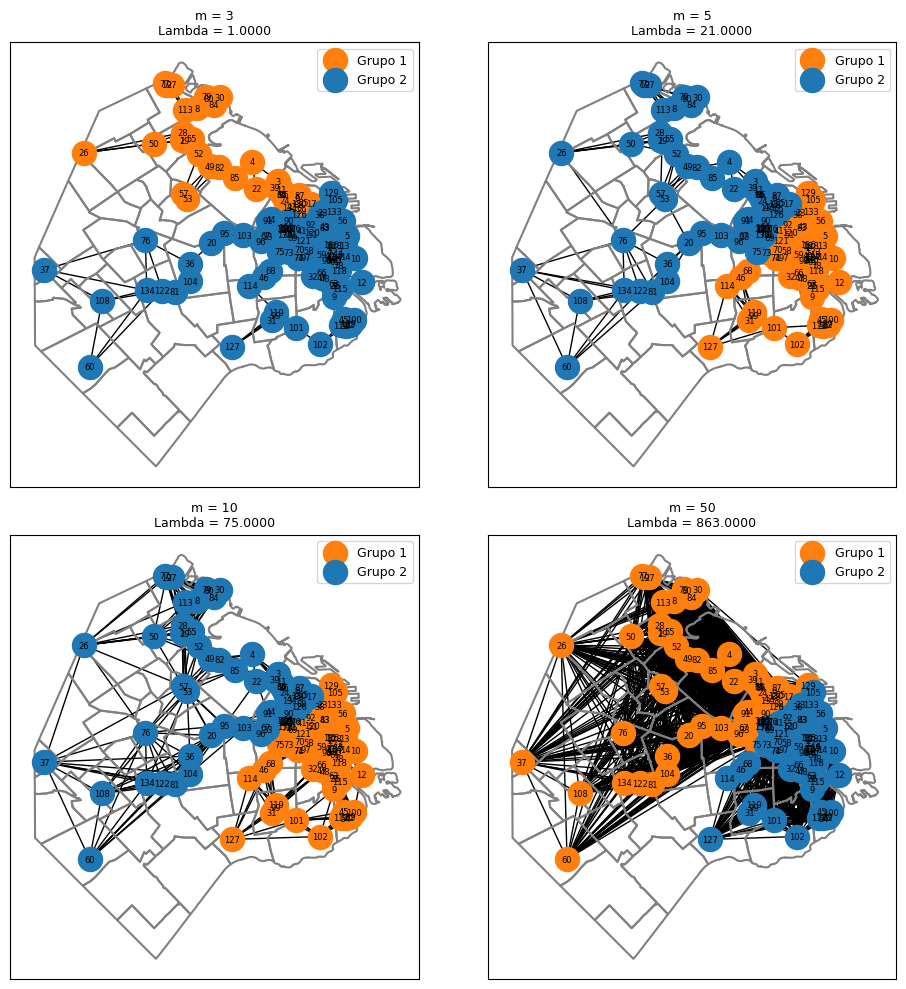

In [181]:
ms = [3, 5, 10, 50]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 filas, 2 columnas
axs = axs.flatten()

for i, m in enumerate(ms):
    A = simetrizar(construye_adyacencia(D, m))
    L = calcula_L(A)
    v, l, _ = metpotI2(L, 1)
    s = np.sign(v)
    lambda_val = calcula_lambda(L, s)

    grupos = laplaciano_iterativo(A, 1)
    M = biparticionar_grafo(A, grupos)
    graficar_grupos(M, grupos, ax=axs[i])
    
    axs[i].set_title(f"m = {m}\nLambda = {lambda_val:.4f}", fontsize=9)

# Ocultar subplots vacíos si hay menos que 4
for j in range(len(ms), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


II) Particiones Óptimas para cada m pedido usando modularidad

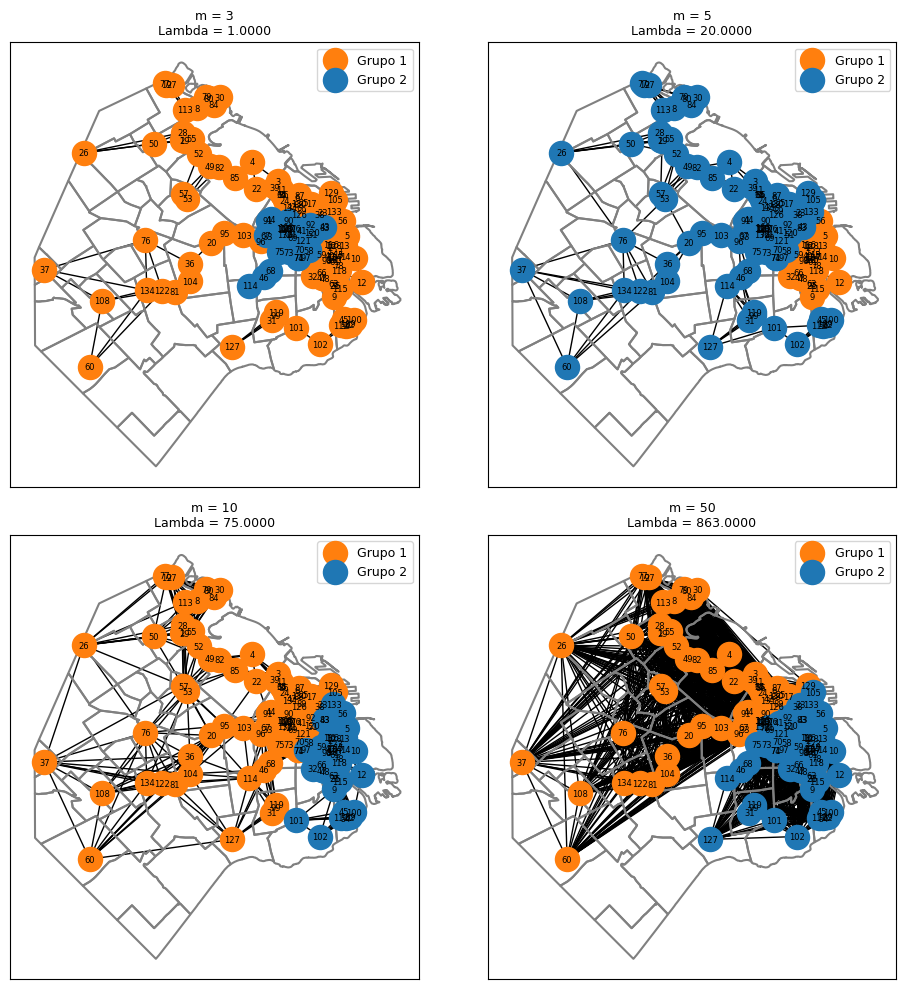

In [183]:
ms = [3, 5, 10, 50]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 filas, 2 columnas
axs = axs.flatten()

for i, m in enumerate(ms):
    A = simetrizar(construye_adyacencia(D, m))
    L = calcula_L(A)
    v, l, _ = metpotI2(L, 1)
    s = np.sign(v)
    lambda_val = calcula_lambda(L, s)

    grupos = modularidad_iterativo(A)
    M = biparticionar_grafo(A, grupos)
    graficar_grupos(M, grupos, ax=axs[i])
    
    axs[i].set_title(f"m = {m}\nLambda = {lambda_val:.4f}", fontsize=9)

# Ocultar subplots vacíos si hay menos que 4
for j in range(len(ms), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
